# pipecaster tutorial

additional libraries requires to execute this notebook:  
* matplotlib  
* scipy  

## Pipeline with score-based channel selection and channel meta-classification

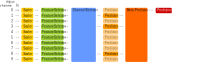

In [1]:
from IPython.display import SVG, display
display(SVG('images/tutorial_01.svg'))

*This pipeline is implemented with the code in the next cell.*  

This example illustrates many of pipecaster's features as well as the performance advantage of using multichannel machine learning.  The pipeline takes 10 input matrices with varying degrees of predictive value.  These matrices might come from ten different data sources or a single data source with ten different feature etraction variants.

**scaling and feature selection**  
The scaler and feauture selector algorithms used, StandardScaler() and SelectPercentile(), are scikit-learn estimator/transformers that are broadcast across all inputs.  

**channel selection**  
The channel selector used, **SelectKBestScores**, computes a univariate feature score for each channel then aggregates the score into a single value using an aggregator function (in this example np.mean).  The top 3 scoring channels are then selected for output.

**base prediction**  
The features output by SelectKBestScores are then used to train one GradientBoostingClassifier for each active channel (3 in this case, since the other 7 channels were not selected).  Pipecaster automatically provides internal cross validation training by default to reduce overfitting of meta-predictors.

** meta-prediction**  
The multichannel meta-predictor, **MultichannelPredictor**, then concatenates the channel into a single feature vector and trains a meta-predictor, in this case scikit-learn's support vector machine classifier SVC.

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import pipecaster as pc

n_input_matrices = 10
random_inputs = 7

Xs, y, X_types = pc.make_multi_input_classification(
                        n_informative_Xs=n_input_matrices-random_inputs, 
                        n_weak_Xs=0,
                        n_random_Xs=random_inputs,
                        weak_noise_sd=None,
                        seed=None,
                        n_classes=2, 
                        n_samples=500, 
                        n_features=100, 
                        n_informative=30, 
                        n_redundant=0, 
                        n_repeated=0, 
                        class_sep=2)  

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf1 = pc.MultichannelPipeline(n_channels=n_input_matrices)
mclf1.add_layer(StandardScaler())
mclf1.add_layer(SelectPercentile(percentile=25))
mclf1.add_layer(pc.SelectKBestScores(feature_scorer=f_classif, aggregator=np.mean, k=3))
mclf1.add_layer(early_stopping_GBC)
mclf1.add_layer(pc.MultichannelPredictor(SVC()))
mclf1

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4
channel,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestScores,→,GradientBoostingClassifier,→,MultichannelPredictor,→
1,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
2,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
3,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
4,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
5,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
6,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
7,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
8,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→


**Notes on graphic visualization**: 
* Before model fitting, all channels show outputs even though some will not be selected.  This is because pipecaster can't tell which channels will be selected prior to model fitting.  
* Inverted triangles indicate that the channels are spanned by the multichannel pipe shown directly above.  
* The channel and layer indices can be used to reference specific object instances in the pipeline (see MultichannelPipeline interface annotations).  

In [4]:
df = mclf1.fit(Xs, y).get_dataframe()
df['input_type'] = X_types
df

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,input_type
channel,,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestScores,→,{GradientBoostingClassifier}cvtr,→,{MultichannelPredictor}tr,→,informative
1,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
2,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
3,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
4,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
5,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
6,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
7,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
8,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random


**Notes on graphic visualization**: 
* The type of input matrix appears in the input_type column on the right.
* The informative inputs, shown in input_type column, should exactly match the output arrows in the out_2 column if channel selection was perfect.
* GradientBoostingClassifier appears in brackets followed by 'cvtr' to indicate that the classifier has been wrapped with a class that provides internal cross validation training to prevent overfitting of downstream metaclassifiers.
* MultichannelPredictor appears in brackets followed by 'tr' to indicate that it has been wrapped to provide a transform() method that predictors ordinarily lacks. 

### Performance analysis

Text(0, 0.5, 'balanced accuracy')

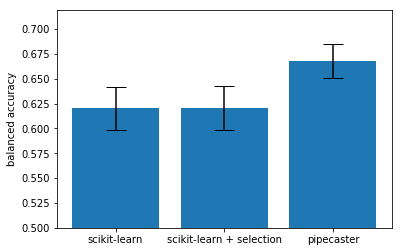

In [6]:
%matplotlib inline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from scipy.stats import sem

pc_accuracies = pc.cross_val_score(mclf1, Xs, y, scorer=balanced_accuracy_score, cv=5)

X = np.concatenate(Xs, axis=1)
clf = Pipeline([('scaler', StandardScaler()), 
                ('selector', SelectPercentile(score_func=f_classif, percentile=25)),
                ('GradientBoostingClassifier', early_stopping_GBC)])
sk_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=5)

clf = Pipeline([('GradientBoostingClassifier', early_stopping_GBC)])
sk_ns_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=5)

plt.bar(['scikit-learn', 'scikit-learn + selection', 'pipecaster'], 
        [np.mean(sk_ns_accuracies), np.mean(sk_accuracies), np.mean(pc_accuracies)], 
        yerr= [sem(sk_ns_accuracies), sem(sk_accuracies), sem(pc_accuracies)], capsize=10)
plt.ylim(.5)
plt.ylabel('balanced accuracy')

**Results**  
The pipecaster pipeline performs better on this task than pipeline architectures that take concatenated features (scikit-learn, and scikit-learn + selection).  The synthetic dataset used in this example consists of 3 informative input matrices and 7 random matrices.  This performance advantage can also be seen with noisy real-world datasets.

Text(0, 0.5, 'balanced accuracy')

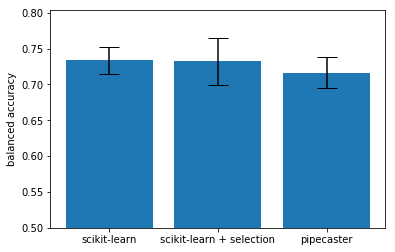

In [8]:
n_input_matrices = 10
random_inputs = 0

Xs, y, X_types = pc.make_multi_input_classification(
                        n_informative_Xs=n_input_matrices-random_inputs, 
                        n_weak_Xs=0,
                        n_random_Xs=random_inputs,
                        weak_noise_sd=None,
                        seed=None,
                        n_classes=2, 
                        n_samples=500, 
                        n_features=100, 
                        n_informative=30, 
                        n_redundant=0, 
                        n_repeated=0, 
                        class_sep=2)  

pc_accuracies = pc.cross_val_score(mclf1, Xs, y, scorer=balanced_accuracy_score, cv=5)

X = np.concatenate(Xs, axis=1)
clf = Pipeline([('scaler', StandardScaler()), 
                ('selector', SelectPercentile(score_func=f_classif, percentile=25)),
                ('GradientBoostingClassifier', early_stopping_GBC)])
sk_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=5)

clf = Pipeline([('GradientBoostingClassifier', early_stopping_GBC)])
sk_ns_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=5)

plt.bar(['scikit-learn', 'scikit-learn + selection', 'pipecaster'], 
        [np.mean(sk_ns_accuracies), np.mean(sk_accuracies), np.mean(pc_accuracies)], 
        yerr= [sem(sk_ns_accuracies), sem(sk_accuracies), sem(pc_accuracies)], capsize=10)
plt.ylim(.5)
plt.ylabel('balanced accuracy')

**Results**  
Multichannel ML doesn't confer a performance advantage on this synthetic dataset when all the input matrices are equally informative.

## Selecting channels with ML probes

This example demonstrates how to select input channels based on the the performance of a temporary ML probe.  Here a low complexity GradientBoostingClassifier probe is used to get an estimate of each input channel's information content using cross validation.  The ML probes and their predictions are then discarded and the selected channels passed through to the next pipeline layer. The pipeline architecture is identical to the one illustrated in example 1.1, except SelectKBestProbes replaces SelectKBestScores.

In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import pipecaster as pc

n_input_matrices = 10
random_inputs = 7

Xs, y, X_types = pc.make_multi_input_classification(
                        n_informative_Xs=n_input_matrices-random_inputs, 
                        n_weak_Xs=0,
                        n_random_Xs=random_inputs,
                        weak_noise_sd=None,
                        seed=None,
                        n_classes=2, 
                        n_samples=500, 
                        n_features=100, 
                        n_informative=30, 
                        n_redundant=0, 
                        n_repeated=0, 
                        class_sep=2)  

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf2 = pc.MultichannelPipeline(n_channels=n_input_matrices)
mclf2.add_layer(StandardScaler())
mclf2.add_layer(SelectPercentile(percentile=25))
probe = GradientBoostingClassifier(n_estimators=10)
mclf2.add_layer(pc.SelectKBestProbes(predictor_probe=probe, cv=3, scorer='auto', k=3))
mclf2.add_layer(early_stopping_GBC)
mclf2.add_layer(pc.MultichannelPredictor(SVC()))
mclf2

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4
channel,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestProbes,→,GradientBoostingClassifier,→,MultichannelPredictor,→
1,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
2,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
3,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
4,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
5,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
6,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
7,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
8,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→


In [10]:
df = mclf2.fit(Xs, y).get_dataframe()
df['input_type'] = X_types
df

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,input_type
channel,,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestProbes,→,{GradientBoostingClassifier}cvtr,→,{MultichannelPredictor}tr,→,informative
1,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
2,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
3,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
4,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
5,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
6,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
7,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
8,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random


**Notes on graphic visualization**: 
* The type of input matrix appears in the input_type column on the right.
* The informative inputs, shown in input_type column, should exactly match the output arrows in the out_2 column if channel selection was perfect.

## Pipeline with score-based channel selection and channel meta-classification

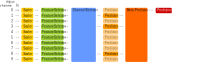

In [1]:
from IPython.display import SVG, display
display(SVG('images/tutorial_01.svg'))

*This pipeline is implemented with the code in the next cell.*  

This example illustrates many of pipecaster's features as well as the performance advantage of using multichannel machine learning.  The pipeline takes 10 input matrices with varying degrees of predictive value.  These matrices might come from ten different data sources or a single data source with ten different feature etraction variants.

**scaling and feature selection**  
The scaler and feauture selector algorithms used, StandardScaler() and SelectPercentile(), are scikit-learn estimator/transformers that are broadcast across all inputs.  

**channel selection**  
The channel selector used, **SelectKBestScores**, computes a univariate feature score for each channel then aggregates the score into a single value using an aggregator function (in this example np.mean).  The top 3 scoring channels are then selected for output.

**base prediction**  
The features output by SelectKBestScores are then used to train one GradientBoostingClassifier for each active channel (3 in this case, since the other 7 channels were not selected).  Pipecaster automatically provides internal cross validation training by default to reduce overfitting of meta-predictors.

** meta-prediction**  
The multichannel meta-predictor, **MultichannelPredictor**, then concatenates the channel into a single feature vector and trains a meta-predictor, in this case scikit-learn's support vector machine classifier SVC.

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import pipecaster as pc

n_input_matrices = 10
random_inputs = 7

Xs, y, X_types = pc.make_multi_input_classification(
                        n_informative_Xs=n_input_matrices-random_inputs, 
                        n_weak_Xs=0,
                        n_random_Xs=random_inputs,
                        weak_noise_sd=None,
                        seed=None,
                        n_classes=2, 
                        n_samples=500, 
                        n_features=100, 
                        n_informative=30, 
                        n_redundant=0, 
                        n_repeated=0, 
                        class_sep=2)  

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf1 = pc.MultichannelPipeline(n_channels=n_input_matrices)
mclf1.add_layer(StandardScaler())
mclf1.add_layer(SelectPercentile(percentile=25))
mclf1.add_layer(pc.SelectKBestScores(feature_scorer=f_classif, aggregator=np.mean, k=3))
mclf1.add_layer(early_stopping_GBC)
mclf1.add_layer(pc.MultichannelPredictor(SVC()))
mclf1

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4
channel,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestScores,→,GradientBoostingClassifier,→,MultichannelPredictor,→
1,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
2,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
3,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
4,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
5,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
6,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
7,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
8,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→


**Notes on graphic visualization**: 
* Before model fitting, all channels show outputs even though some will not be selected.  This is because pipecaster can't tell which channels will be selected prior to model fitting.  
* Inverted triangles indicate that the channels are spanned by the multichannel pipe shown directly above.  
* The channel and layer indices can be used to reference specific object instances in the pipeline (see MultichannelPipeline interface annotations).  

In [4]:
df = mclf1.fit(Xs, y).get_dataframe()
df['input_type'] = X_types
df

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,input_type
channel,,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestScores,→,{GradientBoostingClassifier}cvtr,→,{MultichannelPredictor}tr,→,informative
1,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
2,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
3,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
4,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
5,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
6,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
7,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
8,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random


**Notes on graphic visualization**: 
* The type of input matrix appears in the input_type column on the right.
* The informative inputs, shown in input_type column, should exactly match the output arrows in the out_2 column if channel selection was perfect.
* GradientBoostingClassifier appears in brackets followed by 'cvtr' to indicate that the classifier has been wrapped with a class that provides internal cross validation training to prevent overfitting of downstream metaclassifiers.
* MultichannelPredictor appears in brackets followed by 'tr' to indicate that it has been wrapped to provide a transform() method that predictors ordinarily lacks. 

### Performance analysis

Text(0, 0.5, 'balanced accuracy')

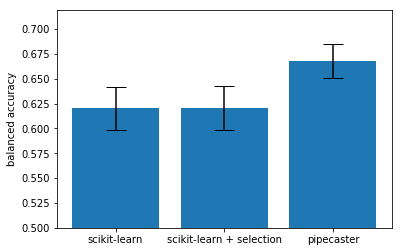

In [6]:
%matplotlib inline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from scipy.stats import sem

pc_accuracies = pc.cross_val_score(mclf1, Xs, y, scorer=balanced_accuracy_score, cv=5)

X = np.concatenate(Xs, axis=1)
clf = Pipeline([('scaler', StandardScaler()), 
                ('selector', SelectPercentile(score_func=f_classif, percentile=25)),
                ('GradientBoostingClassifier', early_stopping_GBC)])
sk_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=5)

clf = Pipeline([('GradientBoostingClassifier', early_stopping_GBC)])
sk_ns_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=5)

plt.bar(['scikit-learn', 'scikit-learn + selection', 'pipecaster'], 
        [np.mean(sk_ns_accuracies), np.mean(sk_accuracies), np.mean(pc_accuracies)], 
        yerr= [sem(sk_ns_accuracies), sem(sk_accuracies), sem(pc_accuracies)], capsize=10)
plt.ylim(.5)
plt.ylabel('balanced accuracy')

**Results**  
The pipecaster pipeline performs better on this task than pipeline architectures that take concatenated features (scikit-learn, and scikit-learn + selection).  The synthetic dataset used in this example consists of 3 informative input matrices and 7 random matrices.  This performance advantage can also be seen with noisy real-world datasets.